In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from my_reviews_loader import BusinessReviewLoader
from my_preprocessor import MyPreProcessor
from feature_engineering import MyFeatureEngineering
from my_sentence_transformer import MySentenceTransformer
from embedding_space_normalizer import EmbeddingSpaceNormalizer
from clustering_evaluator import ClusteringEvaluator
from my_tfidf import MyTFIDF
from theme_extractor import ThemeExtractor

import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
from corpus_denoiser import CorpusDenoiser

ModuleNotFoundError: No module named 'my_reviews_loader'

#### LOAD REVIEWS

In [49]:
# LOAD REVIEWS
loader = BusinessReviewLoader(
    business_path="yelp_dataset/yelp_academic_dataset_business.json",
    reviews_path="yelp_reviews.parquet"
)

biz_reviews = loader.get_reviews_by_business_name("acme oyster house")


✅ Selected Business:
business_id: _ab50qdWOk0DdB6XOrBitw
name: Acme Oyster House
city: New Orleans
state: LA
review_count: 7568
is_open: 1


In [50]:
biz_reviews = biz_reviews[["review_id", "stars", "text", "date"]]

In [51]:
biz_reviews.head()

,review_id,stars,text,date
0,vHLTOsdILT7xgTu7TAWTUQ,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34
1,I90lP6oPICTkrhCFGQt5tA,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16
2,469eAl2fB069YTF_B5zW7w,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39
3,aPpHBDs7Jiiq0sb9YutOhQ,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12
4,k9OG5kA5ebruSx_f1T-P-A,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20


#### PREPROCESS

In [52]:
# PREPROCESS
preprocessor = MyPreProcessor(min_words=3)
clean_reviews = preprocessor.prepare(biz_reviews)

In [53]:
print("Clean Reviews:", clean_reviews.shape)

# pd.set_option("display.max_colwidth", None)

clean_reviews.loc[
    clean_reviews["text_cleaned"].str.contains("jalapeno", case=False, na=False),
    ["text", "text_cleaned"]
].head()

Clean Reviews: (7662, 5)


,text,text_cleaned
151,"I have been to many Acme locations, on many oc...","i have been to many acme locations, on many oc..."
3113,I'm here for work and last night I spent $31 B...,i am here for work and last night i spent $31 ...
7087,This could possibly be a five star joint. But ...,this could possibly be a five star joint. but ...


#### FEATURE ENGINEER

In [54]:
feature_engineer = MyFeatureEngineering()
fe_reviews = feature_engineer.add_features(clean_reviews)

print("Feature-Engineered Shape:", fe_reviews.shape)
fe_reviews[["text_cleaned", "lemmas", "word_count"]].head()


Feature-Engineered Shape: (7662, 10)


,text_cleaned,lemmas,word_count
0,this place has amazing oysters and the best bl...,place amazing oyster best bloody mary stay nol...,107
1,oh my!! a must try. we had no idea there would...,oh must try idea would line definitely well wo...,82
2,the fried seafood was extremely hot. very nice...,fried seafood extremely hot nice taste add sof...,97
3,i love this place. i wish my stay was longer s...,love place wish stay longer could visit food a...,40
4,"loved the chargrilled oysters! i mean, serious...",loved chargrilled oyster mean seriously never ...,230


#### EMBED

In [3]:
# EMBED
embedder = MySentenceTransformer()

X = embedder.encode(fe_reviews["text_cleaned"].tolist())

NameError: name 'MySentenceTransformer' is not defined

In [56]:
fe_reviews['normalized_embeddings'] = list(X)

In [57]:
fe_reviews["n_lemmas"] = fe_reviews.lemmas.str.split().str.len()

In [58]:
fe_reviews.sort_values("n_lemmas").head(5)

,review_id,stars,text,date,text_cleaned,lemmas,word_count,char_count,avg_word_length,sentence_count,normalized_embeddings,n_lemmas
6313,k695cJajbkx49_EN93BF6Q,3.0,Noisy and over-rated. Our po-boys were nothin...,2019-05-29 11:30:12,noisy and over-rated. our po-boys were nothing...,noisy nothing special,8,55,6.000000,2,"[0.021271987, 0.012127214, 0.07098315, -0.0071...",3
3633,NTcfUEkhw5fEzID2vyzPHA,4.0,The Oyster/Shrimp Po' Boy is off the chain!!!,2015-07-31 18:14:45,the oyster/shrimp po' boy is off the chain!!!,po boy chain,8,45,4.750000,3,"[-0.072874956, 0.0690157, 0.019292653, -0.0657...",3
5353,z3gJgHoMvn-HoBpcwxMiUA,3.0,I was not impressed. I got what I came for and...,2016-07-06 00:24:50,i was not impressed. i got what i came for and...,impressed got came,14,57,3.142857,1,"[-0.0551579, 0.0764091, -0.039916154, -0.05428...",3
6239,vRCKn6wlItlJ5-n0oE1s2A,5.0,The best char-grilled oysters anywhere,2013-07-26 13:53:21,the best char-grilled oysters anywhere,best oyster anywhere,5,38,6.800000,1,"[0.015972149, 0.02865614, 0.035901856, -0.0133...",3
3779,IGwoadGt1VVGdF0ryPoVpA,4.0,Delicious! The char-grilled oysters were amaz...,2013-07-09 08:18:52,delicious! the char-grilled oysters were amazi...,delicious oyster amazing,6,51,7.666667,4,"[-0.02660812, 0.06343157, 0.03727083, 0.042128...",3


#### DENOISE

In [59]:
X_raw = fe_reviews.copy()

denoiser = CorpusDenoiser(min_words=6, dup_thresh=0.95)
df, X = denoiser.fit_transform(fe_reviews, X)

In [60]:
X_raw.shape

(7662, 12)

In [61]:
df.shape

(7641, 12)

In [88]:
noise_ids = [b for b in X_raw.review_id if b not in list(df.review_id)]

#### The curse of dimensionality

#### PCA

In [62]:
# Fix embedding space geometry
normalizer = EmbeddingSpaceNormalizer(n_components=30, whiten=False)
X_pca = normalizer.fit_transform(X)

#### EVALUATE K

In [63]:
evaluator = ClusteringEvaluator(random_state=42)

results_df = evaluator.probe_k_range(
    X_raw=X,
    X_cluster=X_pca,
    method="agglo",
    linkage="average",
    metric="cosine",
    k_values=range(2, 10)
)

Evaluating agglo | k=2...
Evaluating agglo | k=3...
Evaluating agglo | k=4...
Evaluating agglo | k=5...
Evaluating agglo | k=6...
Evaluating agglo | k=7...
Evaluating agglo | k=8...
Evaluating agglo | k=9...


In [64]:
results_df.sort_values(
    by=["avg_intra_cosine", "inter_centroid_cosine"],
    ascending=[False, True]
)

,k,method,linkage,avg_intra_cosine,inter_centroid_cosine,cluster_size_std
7,9,agglo,average,0.596181,0.888172,698.682252
6,8,agglo,average,0.593670,0.892848,696.054854
5,7,agglo,average,0.591178,0.899716,681.328504
4,6,agglo,average,0.588205,0.894019,803.662813
3,5,agglo,average,0.585748,0.894565,704.371323
2,4,agglo,average,0.578964,0.894699,1023.389558
1,3,agglo,average,0.570221,0.911564,820.748845
0,2,agglo,average,0.556144,0.932871,1155.500000


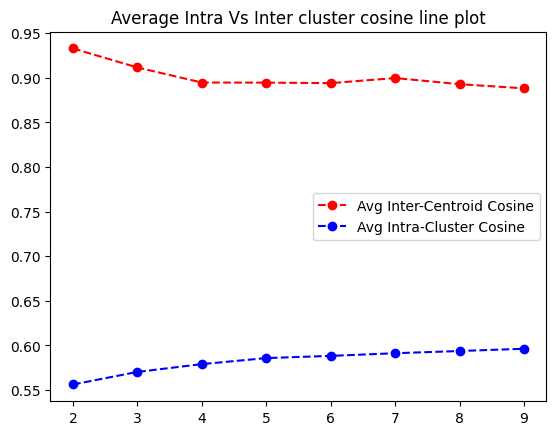

In [65]:
plt.plot(results_df['k'], results_df['inter_centroid_cosine'], marker='o', linestyle='--', c='red', label='Avg Inter-Centroid Cosine')
plt.plot(results_df['k'], results_df['avg_intra_cosine'], marker='o', linestyle='--', c='blue', label='Avg Intra-Cluster Cosine')
plt.title('Average Intra Vs Inter cluster cosine line plot')
plt.legend()
plt.show()

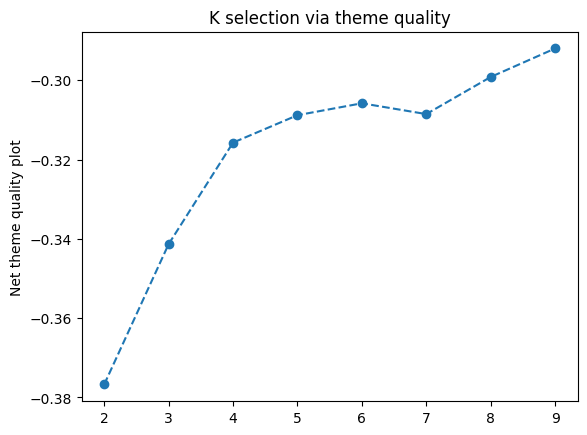

In [66]:
# Net theme quality
plt.plot(results_df['k'], results_df['avg_intra_cosine'] - results_df['inter_centroid_cosine'], marker='o', linestyle='--')
plt.ylabel('Net theme quality plot')
plt.title("K selection via theme quality")
plt.show()

#### PICK BEST_K

In [67]:
# select best k; true geometric elbow
def select_k(results_df):
    """
    Choose k using elbow on net theme quality curve:
    net = intra_cluster_cosine - inter_centroid_cosine
    """
    df = results_df.copy().sort_values('k')

    k_vals = df["k"].values
    net_qual = (df["avg_intra_cosine"] - df["inter_centroid_cosine"]).values

    # Normalize
    k_norm = (k_vals - k_vals.min()) / (k_vals.max() - k_vals.min())
    net_norm = (net_qual - net_qual.min()) / (net_qual.max() - net_qual.min())

    p1 = np.array([k_norm[0], net_norm[0]])
    p2 = np.array([k_norm[-1], net_norm[-1]])
    line_vec = p2 - p1
    line_len = np.linalg.norm(line_vec)

    distances = []
    for x, y in zip(k_norm, net_norm):
        p = np.array([x, y])
        dist = np.abs(
            line_vec[1] * (p[0] - p1[0]) -
            line_vec[0] * (p[1] - p1[1])
        ) / line_len
        distances.append(dist)

    distances = np.array(distances)
    distances[0] = 0
    distances[-1] = 0

    best_idx = distances.argmax()
    best_k = int(k_vals[best_idx])

    return best_k, distances

In [68]:
best_k, elbow_distances = select_k(results_df)
print(f"Auto selected k: {best_k}")
print(f"Elbow distances: {elbow_distances}")

Auto selected k: 4
Elbow distances: [0.         0.19426105 0.30693182 0.26364361 0.18769434 0.06394326
 0.04104106 0.        ]


#### CLUSTER WITH BEST_K

In [69]:
# Fit with AgglomerativeAClustering
# compute distance matrix
model, labels = evaluator.fit_final_clustering(X_cluster=X_pca, k=best_k, method="agglo", linkage='average', metric="cosine")
pd.Series(labels).value_counts()

0    3488
1    1986
2    1488
3     679
Name: count, dtype: int64

In [70]:
labels.shape

(7641,)

In [71]:
# Assign clusters
reviews_df = df.copy()
reviews_df['cluster'] = labels

In [72]:
# Create TF-IDF matrix and extract cluster local top_n top terms
tfidf = MyTFIDF(max_features=8000)

tf_df = tfidf.build_global(reviews_df["text_cleaned"]) # used lemmas before

cluster_terms = tfidf.extract_cluster_terms(
    tf_df=tf_df,
    labels=labels,
    top_n=12
)

In [73]:
for k,v in cluster_terms.items():
    print(f"cluster {k}: {v}")

cluster 0: ['good', 'chargrilled', 'chargrilled oysters', 'line', 'wait', 'great', 'place', 'oyster', 'raw', 'food', 'grilled', 'worth']
cluster 1: ['new', 'orleans', 'new orleans', 'nola', 'place', 'good', 'food', 'acme', 'oyster', 'chargrilled', 'best', 'line']
cluster 2: ['food', 'good', 'great', 'service', 'place', 'wait', 'line', 'gumbo', 'shrimp', 'po', 'got', 'fried']
cluster 3: ['acme', 'oyster', 'good', 'house', 'chargrilled', 'line', 'chargrilled oysters', 'acme oyster', 'oyster house', 'wait', 'just', 'great']


In [74]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [75]:
# Create connect to OPENAI API
from openai import OpenAI
client = OpenAI()

In [76]:
# Extract cluster representaticve reviews and generate theme cards
theme_extractor = ThemeExtractor(client)

# Extract representative examples
cluster_examples = evaluator.extract_representative_examples_medoid(
    X_cluster=X_pca,      
    df=reviews_df,
    labels=labels,
    text_col="text_cleaned",
    top_n=10
)

themes = theme_extractor.generate_all_themes(
    cluster_terms=cluster_terms,
    cluster_examples=cluster_examples
)


In [77]:
themes

{0: {'theme_name': 'Charbroiled Oysters Experience',
  'summary': 'Customers rave about the charbroiled oysters, highlighting their exceptional flavor and recommending the experience despite some wait times.',
  'likes': ['great flavor', 'short wait times'],
  'dislikes': ['long line', 'uncomfortable bar seating'],
  'business_impact': 'High customer satisfaction and repeat visits driven by popular menu items.'},
 1: {'theme_name': 'Oysters and Dining Experience',
  'summary': 'Customers rave about the chargrilled oysters and overall dining experience at Acme Oyster House in New Orleans, highlighting the delicious food and friendly service.',
  'likes': ['chargrilled oysters', 'friendly staff'],
  'dislikes': ['long wait times', 'inconsistent quality of other dishes'],
  'business_impact': 'Positive reviews can enhance reputation and attract more customers, but addressing wait times and dish consistency may improve overall satisfaction.'},
 2: {'theme_name': 'Food Quality and Service',

In [78]:
def consolidate_themes(
    client,
    candidate_themes,
    max_themes=4,
    business_context="Customer reviews",
    model="gpt-4o-mini",
):
    """
    Merge overlapping candidate themes into a final,
    non-overlapping set of business-ready themes.
    """

    prompt = f"""
You are consolidating customer feedback themes.

Context:
{business_context}

You are given several candidate themes extracted from clusters.
Some themes may overlap or describe the same underlying issue.

TASK:
- Merge themes that refer to the same core concept
- Produce at most {max_themes} final themes
- Each final theme must be conceptually distinct
- Use clear, business-friendly language
- Preserve important positives and negatives
- Cite which candidate themes were merged

OUTPUT FORMAT (JSON):
[
  {{
    "final_theme_name": "...",
    "summary": "...",
    "likes": [...],
    "dislikes": [...],
    "business_impact": "...",
    "merged_cluster_ids": [0, 1, 3]
  }}
]

Candidate themes:
{candidate_themes}
"""

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
    )

    return response.choices[0].message.content


In [79]:
final_themes_json = consolidate_themes(
    client=client,
    candidate_themes=themes,
    max_themes=4,
    business_context="Restaurant reviews for Acme Oyster House",
)

In [80]:
final_themes_json

'```json\n[\n  {\n    "final_theme_name": "Oyster Experience and Quality",\n    "summary": "Customers consistently praise the charbroiled and chargrilled oysters for their exceptional flavor, although there are concerns about food quality consistency and issues with sand and shells in oysters.",\n    "likes": ["great flavor", "chargrilled oysters", "delicious chargrilled oysters"],\n    "dislikes": ["inconsistent food quality", "issues with sand and shells in oysters"],\n    "business_impact": "Strong reputation for oysters can drive repeat visits, but quality control issues need to be addressed to maintain customer loyalty.",\n    "merged_cluster_ids": [0, 1, 3]\n  },\n  {\n    "final_theme_name": "Service and Wait Times",\n    "summary": "While customers appreciate the friendly service, there are significant complaints regarding long wait times and inconsistent service experiences.",\n    "likes": ["friendly staff", "great food quality", "friendly waitstaff"],\n    "dislikes": ["long